# What's here:
- using tutorial from streamlit to steer gemma 2 2b
- read out top logits from Hooked Transformer (while steering) ~
    - this is done using a custom hook. There are some cool examples of steering here at the bottom of the notebook.
    - Problem: Uses too much memory of the GPU (cache is way too huge even with 2b model) and INCONSISTENT results. Even when choosing steering coefficient = 1, the top latents are not the same as the one generated with model.generate(). 
    - You can't run this whole notebook in one go (!) run individual cells manually!
        Continued working on this in LetsDriftGemma2_Hooked_continued.ipynb

ENV: lets_drift_env_V1


# Setup
Conda Env == lets_drift_env_V1 
(Which is a clone of arena_env1_1_1c)

## Imports for Gemma Model

In [1]:
import torch as t


In [2]:
device = t.device('mps' if t.backends.mps.is_available() else 'cuda' if t.cuda.is_available() else 'cpu')


In [3]:
from huggingface_hub import login
login()  # This will prompt for your HuggingFace token in a text box


starts with a j..jeje .. f_JTQGGDeycTxPCozthrzqWQhmLpOkaVKXRq

In [7]:
from sae_lens import (
    SAE,
    ActivationsStore,
    HookedSAETransformer,
    LanguageModelSAERunnerConfig,
    SAEConfig,
    SAETrainingRunner,
    upload_saes_to_huggingface,
)
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory
from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
# from transformer_lens import HookedTransformer
from sae_lens import SAE, HookedSAETransformer
import pandas as pd

In [8]:
# for Neuronpedia
from IPython.display import HTML, IFrame, clear_output, display

In [9]:
# for steering impln
from rich import print as rprint
from rich.table import Table
from tqdm.auto import tqdm
from functools import partial
from jaxtyping import Float
from torch import Tensor

# load hooked model -- from Arena 3 Chpt 1.3.2

full list of models in TransformerLens:
https://transformerlensorg.github.io/TransformerLens/generated/model_properties_table.html


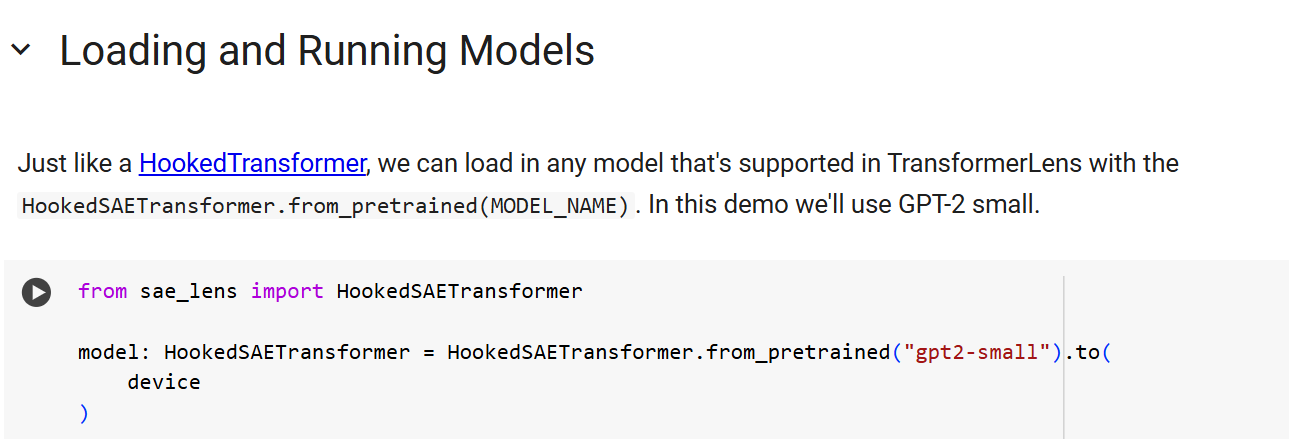

From: https://colab.research.google.com/github/jbloomAus/SAELens/blob/main/tutorials/Hooked_SAE_Transformer_Demo.ipynb

how to configure and import HookedSAETransformer:
https://github.com/jbloomAus/SAELens/blob/main/tutorials/tutorial_2_0.ipynb


In [8]:
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory

# TODO: Make this nicer.
df = pd.DataFrame.from_records(
    {k: v.__dict__ for k, v in get_pretrained_saes_directory().items()}
).T
df.drop(
    columns=[
        "expected_var_explained",
        "expected_l0",
        "config_overrides",
        "conversion_func",
    ],
    inplace=True,
)
df  # Each row is a "release" which has multiple SAEs which may have different configs / match different hook points in a model

,release,repo_id,model,saes_map,neuronpedia_id
gemma-2b-it-res-jb,gemma-2b-it-res-jb,jbloom/Gemma-2b-IT-Residual-Stream-SAEs,gemma-2b-it,{'blocks.12.hook_resid_post': 'gemma_2b_it_blo...,{'blocks.12.hook_resid_post': 'gemma-2b-it/12-...
gemma-2b-res-jb,gemma-2b-res-jb,jbloom/Gemma-2b-Residual-Stream-SAEs,gemma-2b,{'blocks.0.hook_resid_post': 'gemma_2b_blocks....,{'blocks.0.hook_resid_post': 'gemma-2b/0-res-j...
gemma-scope-27b-pt-res,gemma-scope-27b-pt-res,google/gemma-scope-27b-pt-res,gemma-2-27b,{'layer_10/width_131k/average_l0_106': 'layer_...,"{'layer_10/width_131k/average_l0_106': None, '..."
gemma-scope-27b-pt-res-canonical,gemma-scope-27b-pt-res-canonical,google/gemma-scope-27b-pt-res,gemma-2-27b,{'layer_10/width_131k/canonical': 'layer_10/wi...,{'layer_10/width_131k/canonical': 'gemma-2-27b...
gemma-scope-2b-pt-att,gemma-scope-2b-pt-att,google/gemma-scope-2b-pt-att,gemma-2-2b,{'layer_0/width_16k/average_l0_104': 'layer_0/...,"{'layer_0/width_16k/average_l0_104': None, 'la..."
gemma-scope-2b-pt-att-canonical,gemma-scope-2b-pt-att-canonical,google/gemma-scope-2b-pt-att,gemma-2-2b,{'layer_0/width_16k/canonical': 'layer_0/width...,{'layer_0/width_16k/canonical': 'gemma-2-2b/0-...
gemma-scope-2b-pt-mlp,gemma-scope-2b-pt-mlp,google/gemma-scope-2b-pt-mlp,gemma-2-2b,{'layer_0/width_16k/average_l0_119': 'layer_0/...,"{'layer_0/width_16k/average_l0_119': None, 'la..."
gemma-scope-2b-pt-mlp-canonical,gemma-scope-2b-pt-mlp-canonical,google/gemma-scope-2b-pt-mlp,gemma-2-2b,{'layer_0/width_16k/canonical': 'layer_0/width...,{'layer_0/width_16k/canonical': 'gemma-2-2b/0-...
gemma-scope-2b-pt-res,gemma-scope-2b-pt-res,google/gemma-scope-2b-pt-res,gemma-2-2b,{'embedding/width_4k/average_l0_6': 'embedding...,"{'embedding/width_4k/average_l0_6': None, 'emb..."
gemma-scope-2b-pt-res-canonical,gemma-scope-2b-pt-res-canonical,google/gemma-scope-2b-pt-res,gemma-2-2b,{'layer_0/width_16k/canonical': 'layer_0/width...,{'layer_0/width_16k/canonical': 'gemma-2-2b/0-...


Much better way to see all the available Scopes, including methods to import them to your code are here!!
https://www.neuronpedia.org/gemma-scope#browse

In [10]:

gemma_2_2b = HookedSAETransformer.from_pretrained("gemma-2-2b", device=device)

gemmascope_sae_release = "gemma-scope-2b-pt-res-canonical"
gemmascope_sae_id = "layer_20/width_16k/canonical"

gemma_2_2b_sae = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id, device=str(device))[0]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


### Gemma 2 - 2b implementation and then steering implementation from Arena3- 
**Note: had to UPGRADE SAE-Lens version. Apparently, SAEvis and SAEDashboard are not compatible. so they have been kicked from the imports**

#### display gemmaScope dashboard using Neuropedia and custom display_dashboard function

In [10]:
def display_dashboard(
    sae_release="gpt2-small-res-jb",
    sae_id="blocks.7.hook_resid_pre",
    latent_idx=0,
    width=800,
    height=600,
):
    release = get_pretrained_saes_directory()[sae_release]
    neuronpedia_id = release.neuronpedia_id[sae_id]

    url = f"https://neuronpedia.org/{neuronpedia_id}/{latent_idx}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

    print(url)
    display(IFrame(url, width=width, height=height))




In [11]:
latent_idx = 12082

display_dashboard(sae_release=gemmascope_sae_release, sae_id=gemmascope_sae_id, latent_idx=latent_idx)

https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/12082?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


### steering impln - TRY1

In [13]:
# not working -- see implnt 2 below -- this part is self-written -- 
"""
def steering_hook(
    activation: t.Tensor,
    hook: HookPoint,
    sae: SAE,
    latent_idx: int,
    steering_coefficient: float,
) -> t.Tensor:"""
"""
Hook function that adds a multiple of a decoder weight vector to the residual stream.

Args:
    activation: The activation at the hook point (residual stream)
    hook: The hook point object
    sae: The sparse autoencoder object
    latent_idx: Which feature to steer towards
    steering_coefficient: How much to steer (multiplier for the decoder vector)

Returns:
    Modified activation with steering applied
"""
# Get the decoder vector for the specified feature and add it to the last position
# of the sequence, scaled by the steering coefficient
"""

    activation[:, -1] += steering_coefficient * sae.W_dec[:, latent_idx]
    return activation"""

'\n\n    activation[:, -1] += steering_coefficient * sae.W_dec[:, latent_idx]\n    return activation'

In [16]:
"""
#MaxM_
# Choose a latent index between 0 and 2303
latent_idx = 2000  # or any other number < 2304

## The rest is from Arena3:
GENERATE_KWARGS = dict(temperature=0.5, freq_penalty=2.0, verbose=False)


def generate_with_steering(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    latent_idx: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    #Generates text with steering. A multiple of the steering vector (the decoder weight for this latent) is added to
    #the last sequence position before every forward pass.
    """
    _steering_hook = partial(
        steering_hook,
        sae=sae,
        latent_idx=latent_idx,
        steering_coefficient=steering_coefficient,
    )

    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, _steering_hook)]):
        output = model.generate(prompt, max_new_tokens=max_new_tokens, **GENERATE_KWARGS)

    return output


prompt = "When I look at myself in the mirror, I see"

no_steering_output = gemma_2_2b.generate(prompt, max_new_tokens=50, **GENERATE_KWARGS)

table = Table(show_header=False, show_lines=True, title="Steering Output")
table.add_row("Normal", no_steering_output)
for i in tqdm(range(3), "Generating steered examples..."):
    table.add_row(
        f"Steered #{i}",
        generate_with_steering(
            gemma_2_2b,
            gemma_2_2b_sae,
            prompt,
            latent_idx,
            steering_coefficient=240.0,  # roughly 1.5-2x the latent's max activation
        ).replace("\n", "↵"),
    )
rprint(table)"""

Generating steered examples...:   0%|          | 0/3 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (2304) must match the size of tensor b (16384) at non-singleton dimension 1

#### TRY 2..: above 2 blocks don't work

In [11]:
#from solutions.py part of part32_interp_with_saes because solution in Streamlit page isnt commplete - the steering_hook solution was misssing?
def steering_hook(
    activations: Float[Tensor, "batch pos d_in"],
    hook: HookPoint,
    sae: SAE,
    latent_idx: int,
    steering_coefficient: float,
) -> Tensor:
    """
    Steers the model by returning a modified activations tensor, with some multiple of the steering vector added to all
    sequence positions.
    """
    return activations + steering_coefficient * sae.W_dec[latent_idx]


In [12]:
GENERATE_KWARGS = dict(temperature=0.5, freq_penalty=2.0, verbose=False)


In [16]:
def generate_with_steering(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    latent_idx: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    Generates text with steering. A multiple of the steering vector (the decoder weight for this latent) is added to
    the last sequence position before every forward pass.
    """
    _steering_hook = partial(
        steering_hook,
        sae=sae,
        latent_idx=latent_idx,
        steering_coefficient=steering_coefficient,
    )

    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, _steering_hook)]):
        output = model.generate(prompt, max_new_tokens=max_new_tokens, **GENERATE_KWARGS)

    return output

Note that we can choose the value of steering_coefficient based on the maximum activation of the latent we're steering on (it's usually wise to choose quite close to the max activation, but not so far above that you steer the model far out of distribution - however this varies from latent to latent, e.g. in the case of this particular latent we'll find it still produces coherent output quite far above the max activation value). If we didn't have neuronpedia then we couldn't do this, and we'd be better off measuring the max activation over some suitably large dataset to guide what value to choose for our steering coefficient.



In [38]:
prompt = "When I look at myself in the mirror, I see"

no_steering_output = gemma_2_2b.generate(prompt, max_new_tokens=50, **GENERATE_KWARGS)

table = Table(show_header=False, show_lines=True, title="Steering Output")
table.add_row("Normal", no_steering_output)
for i in tqdm(range(3), "Generating steered examples..."):
    table.add_row(
        f"Steered #{i}",
        generate_with_steering(
            gemma_2_2b,
            gemma_2_2b_sae,
            prompt,
            latent_idx,
            steering_coefficient=240.0,  # roughly 1.5-2x the latent's max activation
        ).replace("\n", "↵"), 
        f"Top 10 Latents: {get_top_latents(gemma_2_2b, gemma_2_2b_sae, prompt, top_k=10)}",
    )
rprint(table)

Generating steered examples...:   0%|          | 0/3 [00:00<?, ?it/s]


Latents tensor shape: torch.Size([1, 16384])
First few latent values: [0.0, 0.0, 0.0, 0.0, 0.0]

Top 10 latents for prompt: 'When I look at myself in the mirror, I see'

Latent 3806: 77.786
Latent 3586: 54.781
Latent 3997: 54.531
Latent 9768: 38.580
Latent 8505: 34.142
Latent 6631: 33.230
Latent 7864: 31.237
Latent 914: 30.698
Latent 308: 29.708
Latent 5525: 28.015

Latents tensor shape: torch.Size([1, 16384])
First few latent values: [0.0, 0.0, 0.0, 0.0, 0.0]

Top 10 latents for prompt: 'When I look at myself in the mirror, I see'

Latent 3806: 77.786
Latent 3586: 54.781
Latent 3997: 54.531
Latent 9768: 38.580
Latent 8505: 34.142
Latent 6631: 33.230
Latent 7864: 31.237
Latent 914: 30.698
Latent 308: 29.708
Latent 5525: 28.015

Latents tensor shape: torch.Size([1, 16384])
First few latent values: [0.0, 0.0, 0.0, 0.0, 0.0]

Top 10 latents for prompt: 'When I look at myself in the mirror, I see'

Latent 3806: 77.786
Latent 3586: 54.781
Latent 3997: 54.531
Latent 9768: 38.580
Latent 8505

                                                  Steering Output                                                  
┌────────────┬─────────────────────────────────────────────────┬──────────────────────────────────────────────────┐
│ Normal     │ When I look at myself in the mirror, I see a    │                                                  │
│            │ woman who has come to terms with her mortality  │                                                  │
│            │ and is ready to make the most of every moment.  │                                                  │
│            │                                                 │                                                  │
│            │ I see someone who has overcome many obstacles   │                                                  │
│            │ and challenges in my life, but I am still here. │                                                  │
│            │                                                 │                                                  │
│            │ I see someone who is grateful for               │                                                  │
├────────────┼─────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ Steered #0 │ When I look at myself in the mirror, I see a    │ Top 10 Latents: [(3806, 77.78570556640625),      │
│            │ person who am not proud of. Someone who have    │ (3586, 54.78135299682617), (3997,                │
│            │ let myself down. Someone who have been a victim │ 54.53087615966797), (9768, 38.57971954345703),   │
│            │ of my own mental health issues and someone that │ (8505, 34.14220428466797), (6631,                │
│            │ have lost my self worth and confidence because  │ 33.229827880859375), (7864, 31.237062454223633), │
│            │ of it.↵I am trying to change that. I            │ (914, 30.698026657104492), (308,                 │
│            │                                                 │ 29.70777130126953), (5525, 28.015064239501953)]  │
├────────────┼─────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ Steered #1 │ When I look at myself in the mirror, I see a    │ Top 10 Latents: [(3806, 77.78570556640625),      │
│            │ woman who am proud of.  I have spent a lot of   │ (3586, 54.78135299682617), (3997,                │
│            │ time over the years trying to be someone that I │ 54.53087615966797), (9768, 38.57971954345703),   │
│            │ was not.  I tried to be what other people       │ (8505, 34.14220428466797), (6631,                │
│            │ thought I should be and not what God wanted her │ 33.229827880859375), (7864, 31.237062454223633), │
│            │ to be.  I                                       │ (914, 30.698026657104492), (308,                 │
│            │                                                 │ 29.70777130126953), (5525, 28.015064239501953)]  │
├────────────┼─────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ Steered #2 │ When I look at myself in the mirror, I see a    │ Top 10 Latents: [(3806, 77.78570556640625),      │
│            │ woman who am very proud of.↵↵I have done things │ (3586, 54.78135299682617), (3997,                │
│            │ that I never thought I would do, and have made  │ 54.53087615966797), (9768, 38.57971954345703),   │
│            │ my dreams come true.↵↵I am a person who love to │ (8505, 34.14220428466797), (6631,                │
│            │ travel and meet new people and experience       │ 33.229827880859375), (7864, 31.237062454223633), │
│            │ different cultures.↵↵This blog                  │ (914, 30.698026657104492), (308,                 │
│            │                                                 │ 29.70777130126953), (5525, 28.015064239501953)]  │
└────────────┴──────────────────────────────────────────

note in the implementation above, teh top 10 latents are NOT correct, only for steered #2 do they make sense.
latent_idx I think was also a differnet one than going forward in this notebook!

# Read Logits from Hooked Transf .... while steering

In [39]:
#this part onwards; not from tutorial 8)
from einops import rearrange
import torch.nn.functional as F
DEBUG_PRINT = True
def get_top_latents(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    top_k: int = 10,
    bDEBUG_PRINT = DEBUG_PRINT
) -> list:
    """
    Get the top k most activated latents for the last token of a prompt.
    """
    # Get activations at the SAE hook point
    cache = model.run_with_cache(prompt)[1]  # Run model and get cache
    activations = cache[sae.cfg.hook_name]   # Get activations from the specific hook point
    
    # Get last token's activations and reshape if needed
    last_token_acts = activations[:, -1, :]  # [batch, d_model]
    
    # Get SAE activations
    latents = sae.encode(last_token_acts)  # [batch, n_learned_features]
    # Print shape and first few values of latents tensor
    if bDEBUG_PRINT: 
        print(f"\nLatents tensor shape: {latents.shape}")
        print(f"First few latent values: {latents[0, :5].tolist()}")
    # Get top k latents and their indices
    top_k_values, top_k_indices = t.topk(latents[0], k=top_k)
    
    # Create results list of (latent_idx, activation_value) pairs
    results = list(zip(top_k_indices.tolist(), top_k_values.tolist()))
    
    # Print results
    if bDEBUG_PRINT:
        print(f"\nTop {top_k} latents for prompt: '{prompt}'\n")
        for idx, value in results:
            print(f"Latent {idx}: {value:.3f}")
    
    return results

In [36]:
prompt = "When I look at myself in the mirror, I see"
top_latents = get_top_latents(gemma_2_2b, gemma_2_2b_sae, prompt)


Latents tensor shape: torch.Size([1, 16384])
First few latent values: [0.0, 0.0, 0.0, 0.0, 0.0]

Top 10 latents for prompt: 'When I look at myself in the mirror, I see'

Latent 3806: 77.786
Latent 3586: 54.781
Latent 3997: 54.531
Latent 9768: 38.580
Latent 8505: 34.142
Latent 6631: 33.230
Latent 7864: 31.237
Latent 914: 30.698
Latent 308: 29.708
Latent 5525: 28.015


In [37]:
def display_dashboard(
    sae_release="gpt2-small-res-jb",  # The SAE model release name
    sae_id="blocks.7.hook_resid_pre",  # The specific hook point/layer
    latent_idx=0,                      # The feature number you want to inspect
    width=800,
    height=600,
):
    # Get the release info from the pretrained SAEs directory
    release = get_pretrained_saes_directory()[sae_release]
    # Get the Neuronpedia ID for this specific SAE configuration
    neuronpedia_id = release.neuronpedia_id[sae_id]

    # Construct the Neuronpedia URL with embed parameters
    url = f"https://neuronpedia.org/{neuronpedia_id}/{latent_idx}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

    print(url)
    # Display the dashboard in an iframe
    display(IFrame(url, width=width, height=height))

# Example usage:
latent_idx = 3997  # The feature number you want to inspect
display_dashboard(
    sae_release=gemmascope_sae_release,
    sae_id=gemmascope_sae_id, 
    latent_idx=latent_idx
)

https://neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/3997?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


What we've seen: The top latents found by the function above make sense!! Which is super exciting.
However, we are using model.run_with_cache, and when steering, we use model.generate, giving different results and outputs. 

the next part: 
# generate with steering and cache
--> to get the activations at the hookpoint, even when generating with steering (fingers crossed)

In [14]:
GENERATE_KWARGS = dict(temperature=0.5, freq_penalty=2.0, verbose=False)
latent_idx = 3997 
#CONFIG 

In [15]:
def generate_with_steering_and_cache(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    latent_idx: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    Generates text with steering and returns both the output text and activation caches.
    Returns a tuple of (generated_text, list_of_caches) where list_of_caches contains
    the activation cache for each generation step.
    """
    _steering_hook = partial(
        steering_hook,
        sae=sae,
        latent_idx=latent_idx,
        steering_coefficient=steering_coefficient,
    )
    
    generated_tokens = []
    all_caches = []
    
    # Start with the prompt
    tokens = model.to_tokens(prompt)
    
    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, _steering_hook)]):
        for i in range(max_new_tokens):
            # Run model with cache for current sequence
            logits, cache = model.run_with_cache(tokens)
            all_caches.append(cache)
            
            # Get next token using the same generation parameters
            next_token = model.generate_next_token(
                tokens,
                temperature=GENERATE_KWARGS['temperature'],
                freq_penalty=GENERATE_KWARGS['freq_penalty']
            )
            
            # Add token to sequence
            tokens = t.cat([tokens, next_token], dim=-1)
            generated_tokens.append(next_token)
            
            # Optional: check for end of text token
            if next_token.item() == model.end_token_id:
                break
    
    # Convert tokens to text
    output_text = model.to_string(tokens)
    
    return output_text, all_caches




In [16]:
import torch.nn.functional as F
import torch

In [17]:
def generate_with_steering_and_cache(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    latent_idx: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    Generates text with steering and returns both the output text and activation caches.
    Returns a tuple of (generated_text, list_of_caches).
    """
    _steering_hook = partial(
        steering_hook,
        sae=sae,
        latent_idx=latent_idx,
        steering_coefficient=steering_coefficient,
    )
    
    generated_tokens = []
    all_caches = []
    
    # Start with the prompt
    tokens = model.to_tokens(prompt)
    
    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, _steering_hook)]):
        for i in range(max_new_tokens):
            # Run model with cache for current sequence
            logits, cache = model.run_with_cache(tokens)
            all_caches.append(cache)
            
            # Get next token using logits from the last position
            last_token_logits = logits[0, -1, :]
            
            # Apply temperature
            if GENERATE_KWARGS['temperature'] > 0:
                last_token_logits = last_token_logits / GENERATE_KWARGS['temperature']
            
            # Apply frequency penalty if specified
            if GENERATE_KWARGS.get('freq_penalty', 0) > 0:
                # Count token frequencies
                unique_tokens, counts = torch.unique(tokens, return_counts=True)
                freq_penalty = torch.zeros_like(last_token_logits)
                freq_penalty[unique_tokens] = counts.float() * GENERATE_KWARGS['freq_penalty']
                last_token_logits = last_token_logits - freq_penalty
            
            # Sample from the distribution
            probs = F.softmax(last_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            # Add token to sequence
            tokens = t.cat([tokens, next_token.unsqueeze(0)], dim=-1)
            generated_tokens.append(next_token)
            
            # Stop if we've generated max_new_tokens OR hit an EOS token
            if (i >= max_new_tokens - 1) or (next_token.item() == model.tokenizer.eos_token_id):
                break
    
    # Convert tokens to text
    output_text = model.to_string(tokens[0])  # Note: using tokens[0] to get the first batch
    
    return output_text, all_caches

In [18]:

# Function to analyze latents at each generation step
def analyze_generation_latents(caches, sae, top_k=10):
    """
    Analyzes the top latents for each generation step.
    """
    all_top_latents = []
    
    for cache in caches:
        # Get activations at the SAE hook point
        activations = cache[sae.cfg.hook_name]
        
        # Get last token's activations
        last_token_acts = activations[:, -1, :]
        
        # Get SAE activations
        latents = sae.encode(last_token_acts)
        
        # Get top k latents
        top_k_values, top_k_indices = t.topk(latents[0], k=top_k)
        
        # Store results
        all_top_latents.append(list(zip(top_k_indices.tolist(), top_k_values.tolist())))
    
    return all_top_latents


In [54]:
# Example usage:
prompt = "When I look at myself in the mirror, I see"
output_text, caches = generate_with_steering_and_cache(
    gemma_2_2b,
    gemma_2_2b_sae,
    prompt,
    latent_idx,
    steering_coefficient=240.0
)

In [56]:
print(output_text)

<bos>When I look at myself in the mirror, I see a woman who am not proud of. I have a lot of insecurities and my biggest insecurity am my weight. I have been overweight all my life and have struggled with this issue for most of my life.

I know that being overweight affect me in


### Kinda interesting..: Show highest latents at each forward pass

this didn't go quite as planned but cool to see the highest latents over 50 steps!

In [55]:

# Get top latents for each generation step
top_latents_per_step = analyze_generation_latents(caches, gemma_2_2b_sae)

# Print results
print(f"Generated text: {output_text}\n")
print("Top latents at each generation step:")
for i, step_latents in enumerate(top_latents_per_step):
    print(f"\nStep {i}:")
    for idx, value in step_latents[:5]:  # Show top 5 for each step
        print(f"Latent {idx}: {value:.3f}")

Generated text: <bos>When I look at myself in the mirror, I see a woman who am not proud of. I have a lot of insecurities and my biggest insecurity am my weight. I have been overweight all my life and have struggled with this issue for most of my life.

I know that being overweight affect me in

Top latents at each generation step:

Step 0:
Latent 3997: 275.593
Latent 3806: 80.671
Latent 11133: 56.494
Latent 3586: 55.928
Latent 8762: 42.985

Step 1:
Latent 3997: 241.056
Latent 9982: 116.961
Latent 6631: 71.565
Latent 15925: 45.635
Latent 10873: 44.939

Step 2:
Latent 3997: 241.618
Latent 12402: 53.850
Latent 2912: 53.451
Latent 6631: 48.162
Latent 11133: 43.383

Step 3:
Latent 3997: 239.476
Latent 2586: 94.126
Latent 10461: 48.482
Latent 11133: 41.740
Latent 10873: 39.962

Step 4:
Latent 3997: 241.902
Latent 9759: 116.503
Latent 5396: 56.084
Latent 13346: 48.947
Latent 2801: 48.759

Step 5:
Latent 3997: 245.001
Latent 6684: 85.349
Latent 13346: 85.036
Latent 11603: 54.151
Latent 15596:

## 2nd try: increase steering coefficient 2 times & only read out final latents (on last pass)

In [19]:
prompt = "When I look at myself in the mirror, I see"
no_steering_output = gemma_2_2b.generate(prompt, max_new_tokens=50, **GENERATE_KWARGS)


In [20]:
latent_idx

3997

In [64]:
"""prompt = "When I look at myself in the mirror, I see"

no_steering_output = gemma_2_2b.generate(prompt, max_new_tokens=50, **GENERATE_KWARGS)

table = Table(show_header=False, show_lines=True, title="Steering Output")
table.add_row("Normal", no_steering_output)
for i in tqdm(range(3), "Generating steered examples..."):
    output_text, caches = generate_with_steering_and_cache(
        gemma_2_2b,
        gemma_2_2b_sae,
        prompt,
        latent_idx,
        steering_coefficient=240.0 # roughly 1.5-2x the latent's max activation 
    ) 
    top_latents_per_step = analyze_generation_latents(caches, gemma_2_2b_sae)
    table.add_row(
        f"Steered #{i}",
        output_text.replace("\n", "↵"), 
        f"Top 10 Latents: {top_latents_per_step[-1][:10]}",
    )
rprint(table)""" #CUDA RUN OUT OF MEMORY :(

'prompt = "When I look at myself in the mirror, I see"\n\nno_steering_output = gemma_2_2b.generate(prompt, max_new_tokens=50, **GENERATE_KWARGS)\n\ntable = Table(show_header=False, show_lines=True, title="Steering Output")\ntable.add_row("Normal", no_steering_output)\nfor i in tqdm(range(3), "Generating steered examples..."):\n    output_text, caches = generate_with_steering_and_cache(\n        gemma_2_2b,\n        gemma_2_2b_sae,\n        prompt,\n        latent_idx,\n        steering_coefficient=240.0 # roughly 1.5-2x the latent\'s max activation \n    ) \n    top_latents_per_step = analyze_generation_latents(caches, gemma_2_2b_sae)\n    table.add_row(\n        f"Steered #{i}",\n        output_text.replace("\n", "↵"), \n        f"Top 10 Latents: {top_latents_per_step[-1][:10]}",\n    )\nrprint(table)'

Above code runs out of CUDA memory.. Not sure if it could be further optimized, by not trying to save the logits in every pass!
Below code yields the following (shared) memory usage -- runs quite a bit slower than usual 2b model as well.. 
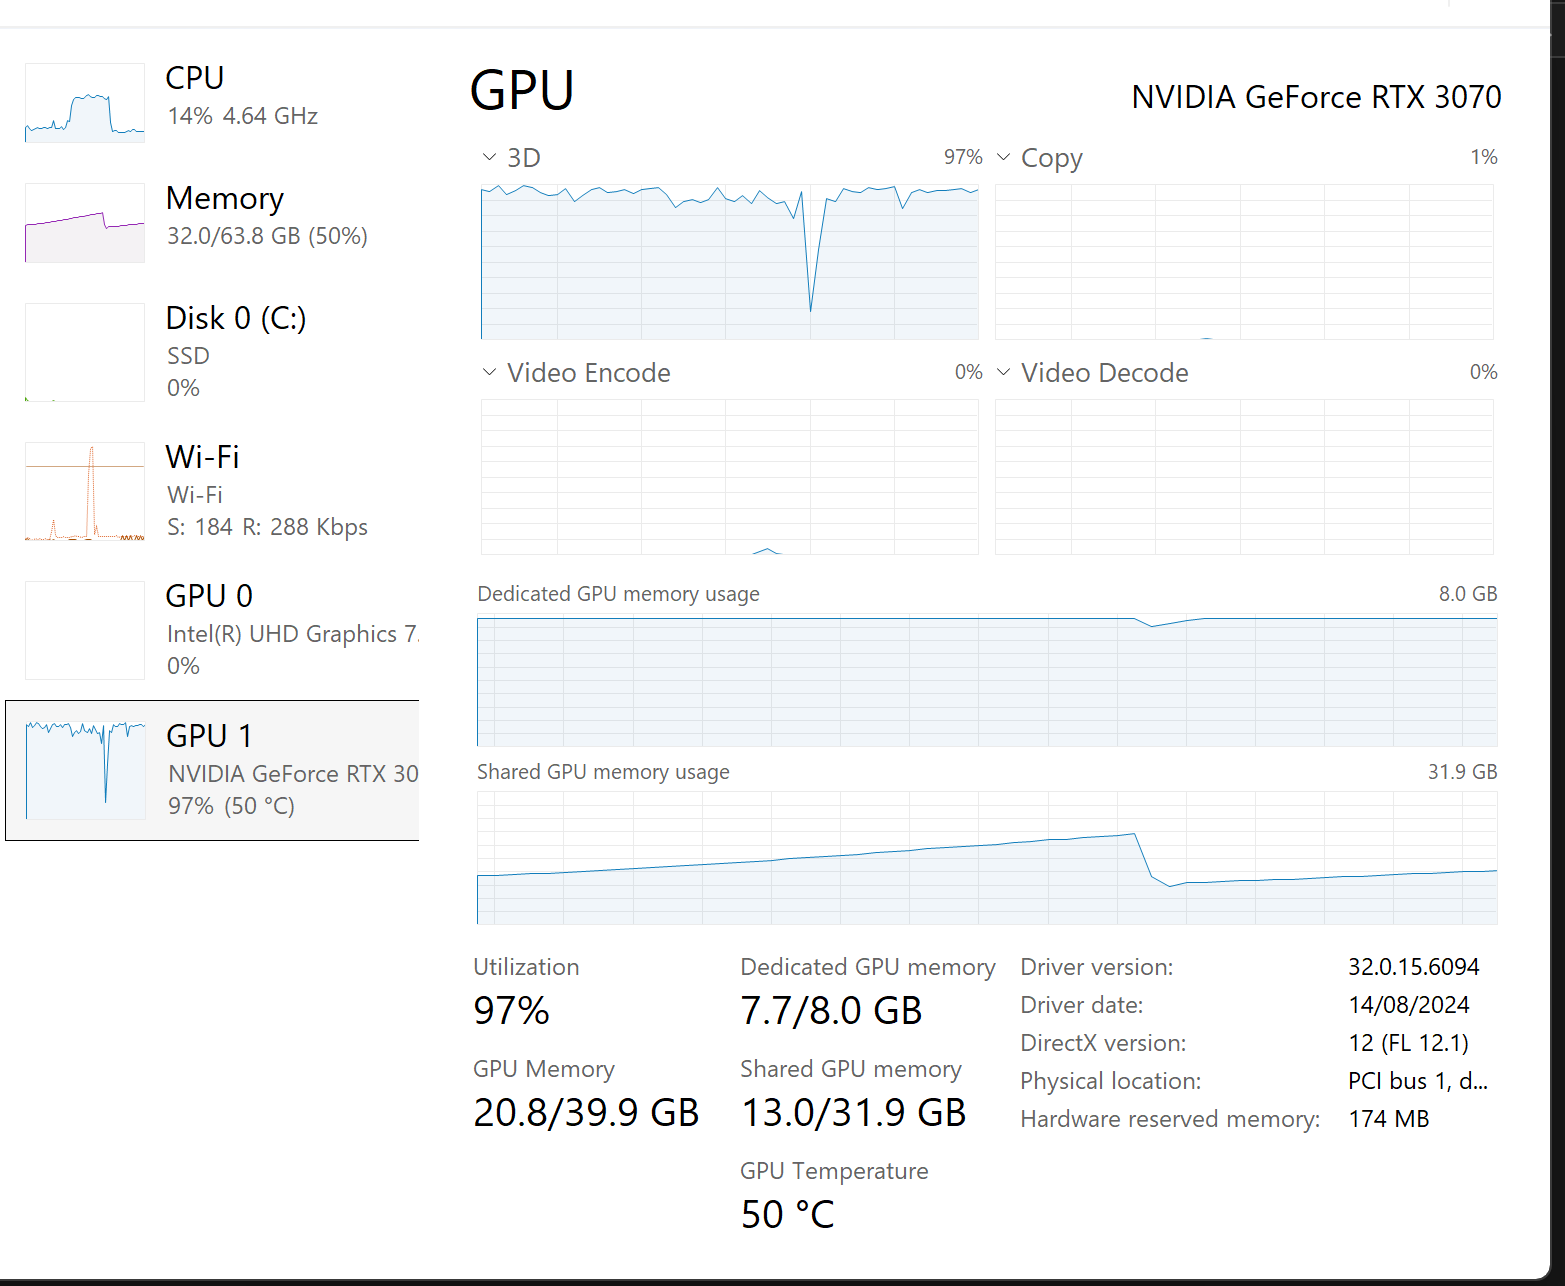

In [25]:
latent_idx = 12082 # this is the one from the original example, "References to dog behaviour and interactions." THis is also what the steering_coefficient value in the solutions was based on!

In [26]:
prompt = "When I look at myself in the mirror, I see"

#no_steering_output = gemma_2_2b.generate(prompt, max_new_tokens=50, **GENERATE_KWARGS)
no_steering_output, caches = generate_with_steering_and_cache(
    gemma_2_2b,
    gemma_2_2b_sae,
    prompt,
    latent_idx,
    steering_coefficient=1 # 1 should equal no steering?
)
final_latents = analyze_generation_latents([caches[-1]], gemma_2_2b_sae)[0][:10]
final_latents_cpu = [(idx, float(val)) for idx, val in final_latents]
    
table = Table(show_header=False, show_lines=True, title="Steering Output")
table.add_row("Normal", no_steering_output, f"Top 10: {final_latents_cpu}")
print("Cache shapes:")
for i, cache in enumerate(caches):
    print(f"Cache {i} shape:", {k: v.shape for k,v in cache.items()})
del caches
t.cuda.empty_cache()  # Clear CUDA cache

for i in tqdm(range(3), "Generating steered examples..."):
    # Generate steered text and get caches
    output_text, caches = generate_with_steering_and_cache(
        gemma_2_2b,
        gemma_2_2b_sae,
        prompt,
        latent_idx,
        steering_coefficient=240.0
    )
    
    # Get top latents from final step only and move to CPU
    final_latents = analyze_generation_latents([caches[-1]], gemma_2_2b_sae)[0][:10]
    final_latents_cpu = [(idx, float(val)) for idx, val in final_latents]
    
    # Add to table
    table.add_row(
        f"Steered #{i}",
        output_text.replace("\n", "↵"),
        f"Top 10: {final_latents_cpu}"
    )
    
    # Clear memory
    del caches
    t.cuda.empty_cache()  # Clear CUDA cache
    
rprint(table)

Cache shapes:
Cache 0 shape: {'hook_embed': torch.Size([1, 12, 2304]), 'blocks.0.hook_resid_pre': torch.Size([1, 12, 2304]), 'blocks.0.ln1.hook_scale': torch.Size([1, 12, 1]), 'blocks.0.ln1.hook_normalized': torch.Size([1, 12, 2304]), 'blocks.0.attn.hook_q': torch.Size([1, 12, 8, 256]), 'blocks.0.attn.hook_k': torch.Size([1, 12, 4, 256]), 'blocks.0.attn.hook_v': torch.Size([1, 12, 4, 256]), 'blocks.0.attn.hook_rot_q': torch.Size([1, 12, 8, 256]), 'blocks.0.attn.hook_rot_k': torch.Size([1, 12, 4, 256]), 'blocks.0.attn.hook_attn_scores': torch.Size([1, 8, 12, 12]), 'blocks.0.attn.hook_pattern': torch.Size([1, 8, 12, 12]), 'blocks.0.attn.hook_z': torch.Size([1, 12, 8, 256]), 'blocks.0.ln1_post.hook_scale': torch.Size([1, 12, 1]), 'blocks.0.ln1_post.hook_normalized': torch.Size([1, 12, 2304]), 'blocks.0.hook_attn_out': torch.Size([1, 12, 2304]), 'blocks.0.hook_resid_mid': torch.Size([1, 12, 2304]), 'blocks.0.ln2.hook_scale': torch.Size([1, 12, 1]), 'blocks.0.ln2.hook_normalized': torch.Siz

Generating steered examples...:   0%|          | 0/3 [00:00<?, ?it/s]

                                                  Steering Output                                                  
┌────────────┬─────────────────────────────────────────────────┬──────────────────────────────────────────────────┐
│ Normal     │ <bos>When I look at myself in the mirror, I see │ Top 10: [(7400, 92.44889831542969), (14065,      │
│            │ a woman who has been through more than her fair │ 46.974891662597656), (4590, 45.12583923339844),  │
│            │ share of ups and downs. There have been times   │ (9741, 43.749263763427734), (3997,               │
│            │ when I’ve felt like a failure; other times,     │ 43.295867919921875), (12256,                     │
│            │ like a hero.                                    │ 43.115848541259766), (1548, 40.507694244384766), │
│            │                                                 │ (6631, 38.95472717285156), (8388,                │
│            │ I started my own business in 2013 and it        │ 37.28106689453125), (1579, 35.71711730957031)]   │
├────────────┼─────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ Steered #0 │ <bos>When I look at myself in the mirror, I see │ Top 10: [(12082, 233.4547576904297), (8722,      │
│            │ a little bit of my dad. He was a handsome man,  │ 79.01807403564453), (7158, 45.08056640625),      │
│            │ and he had an excellent sense of humor. He was  │ (8820, 44.104042053222656), (3223,               │
│            │ the best father ever, and I will never forget   │ 43.95476531982422), (2282, 31.72821044921875),   │
│            │ him.↵↵If you are looking for a dog that is good │ (8573, 28.219562530517578), (5752,               │
│            │ with children,                                  │ 28.07048988342285), (1692, 27.25664520263672),   │
│            │                                                 │ (3985, 25.54871940612793)]                       │
├────────────┼─────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ Steered #1 │ <bos>When I look at myself in the mirror, I see │ Top 10: [(12082, 289.0339050292969), (10461,     │
│            │ a woman who is well-trained, well-behaved and   │ 98.95906066894531), (2468, 48.31441116333008),   │
│            │ well-mannered.↵↵But when I look at my dog, she  │ (4310, 42.00674819946289), (11047,               │
│            │ sees a gentle giant with a heart full of love   │ 39.45550537109375), (14226, 38.3113899230957),   │
│            │ and loyalty. She thinks that we are best        │ (11683, 38.034820556640625), (11288,             │
│            │ friends because she loves                       │ 37.12035369873047), (1283, 32.28558349609375),   │
│            │                                                 │ (12545, 30.875123977661133)]                     │
├────────────┼─────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│ Steered #2 │ <bos>When I look at myself in the mirror, I see │ Top 10: [(12082, 223.74557495117188), (8681,     │
│            │ a person who is a little afraid of being        │ 89.15656280517578), (9951, 67.10194396972656),   │
│            │ alone.↵↵I have always been an obedient dog,     │ (15509, 47.446468353271484), (6122,              │
│            │ wagging my tail when it comes to obedience.↵↵I  │ 40.593692779541016), (5075, 37.88386535644531),  │
│            │ have never been a leader. I am not the first    │ (8708, 36.610328674316406), (8530,               │
│            │ one to jump into the water and                  │ 32.40385055541992), (12273, 31.389720916748047), │
│            │                                                 │ (2468, 30.86962127685547)]                       │
└────────────┴─────────────────────────────────────────────────┴──────────────────────────────────────────────────┘

1st run when using model.generate() gives the following 'normal' non-steered output.
Questions to the above.. Why does idx 3997 (which is the steered feature) never go to 240 (steering coefficient?) and why does it only change a lil in every iteration? --> need to get a better understand of this part of the code! 
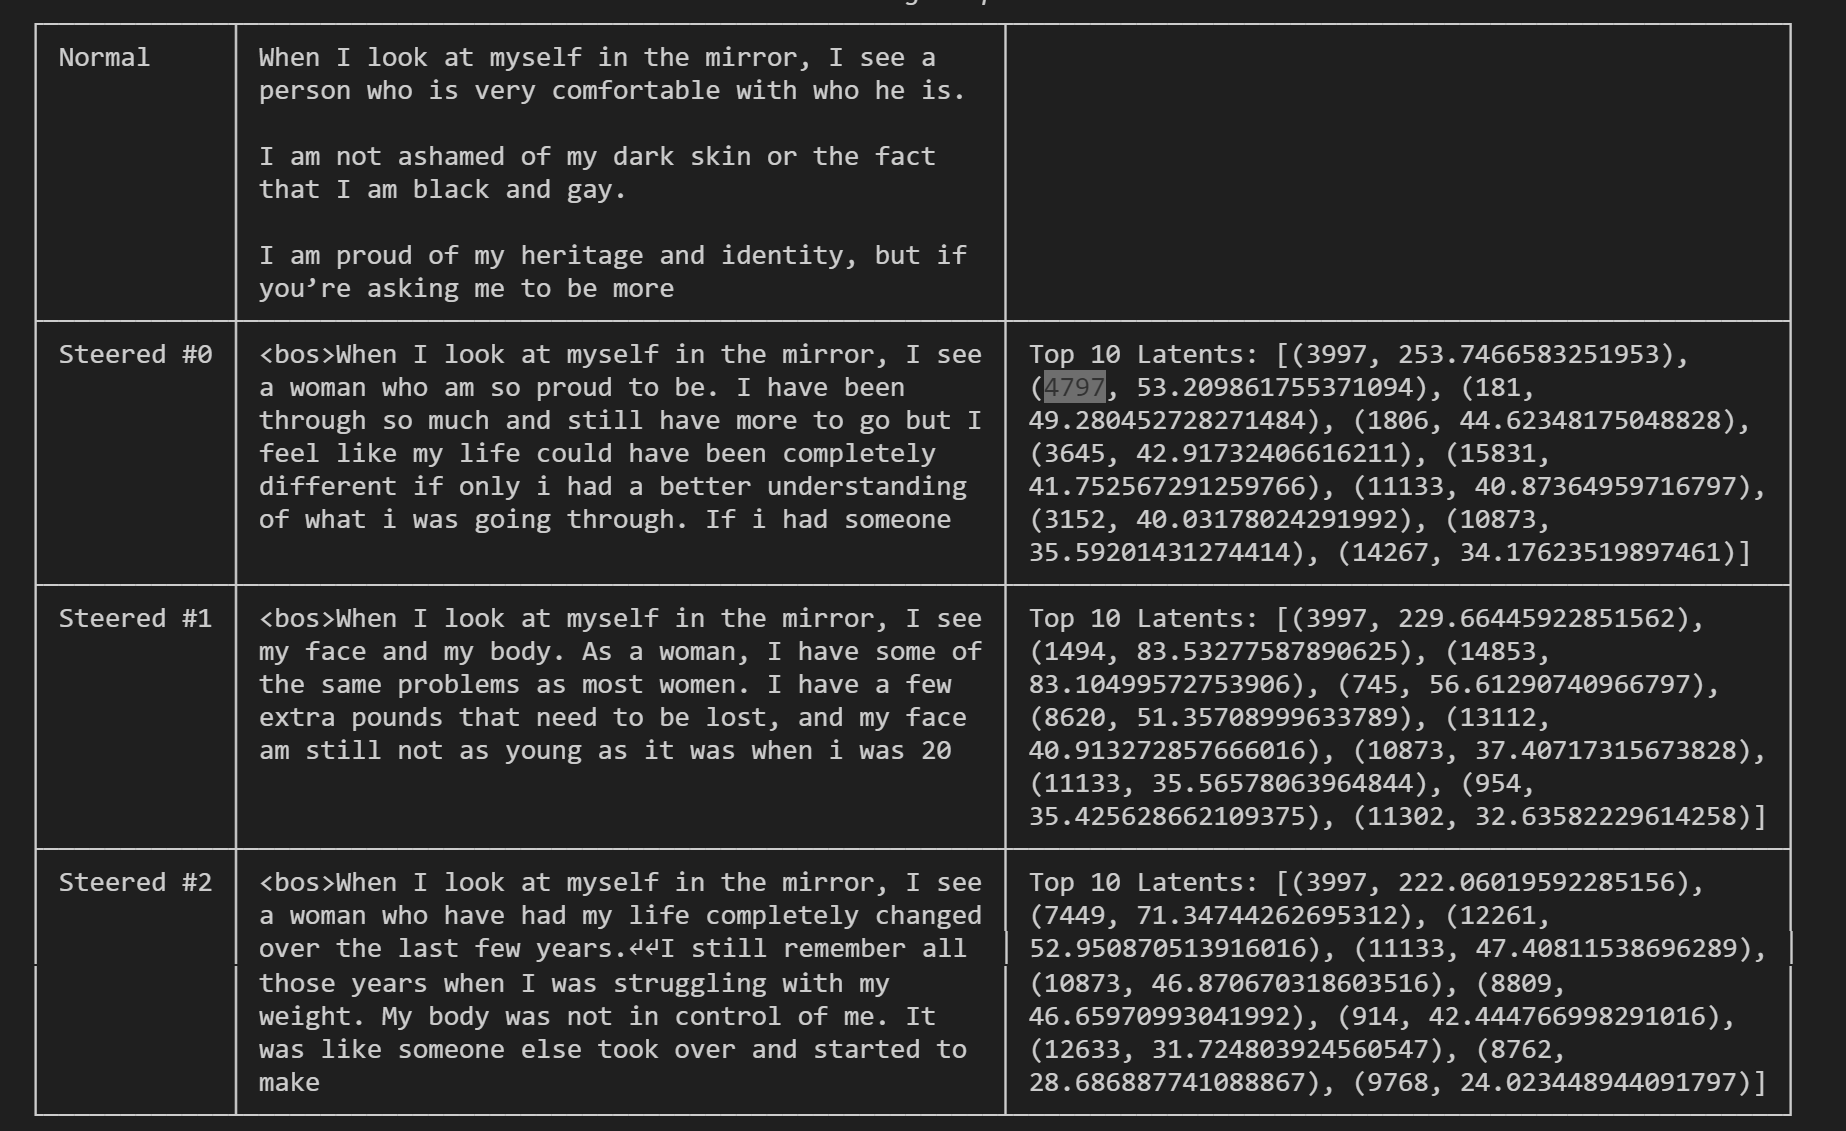

Then here, second run when using same idx and coeff =1 for the 'normal' non steered output --> Not sure how good that implementation is. Also printing out the cache looks like I didn't just get the layer that's hooked. But ALL activations of the whole model :D :D which is both useful and crazy and totally too much --> Tomorrows taks: Fix this. Look at 1 layer at a time...
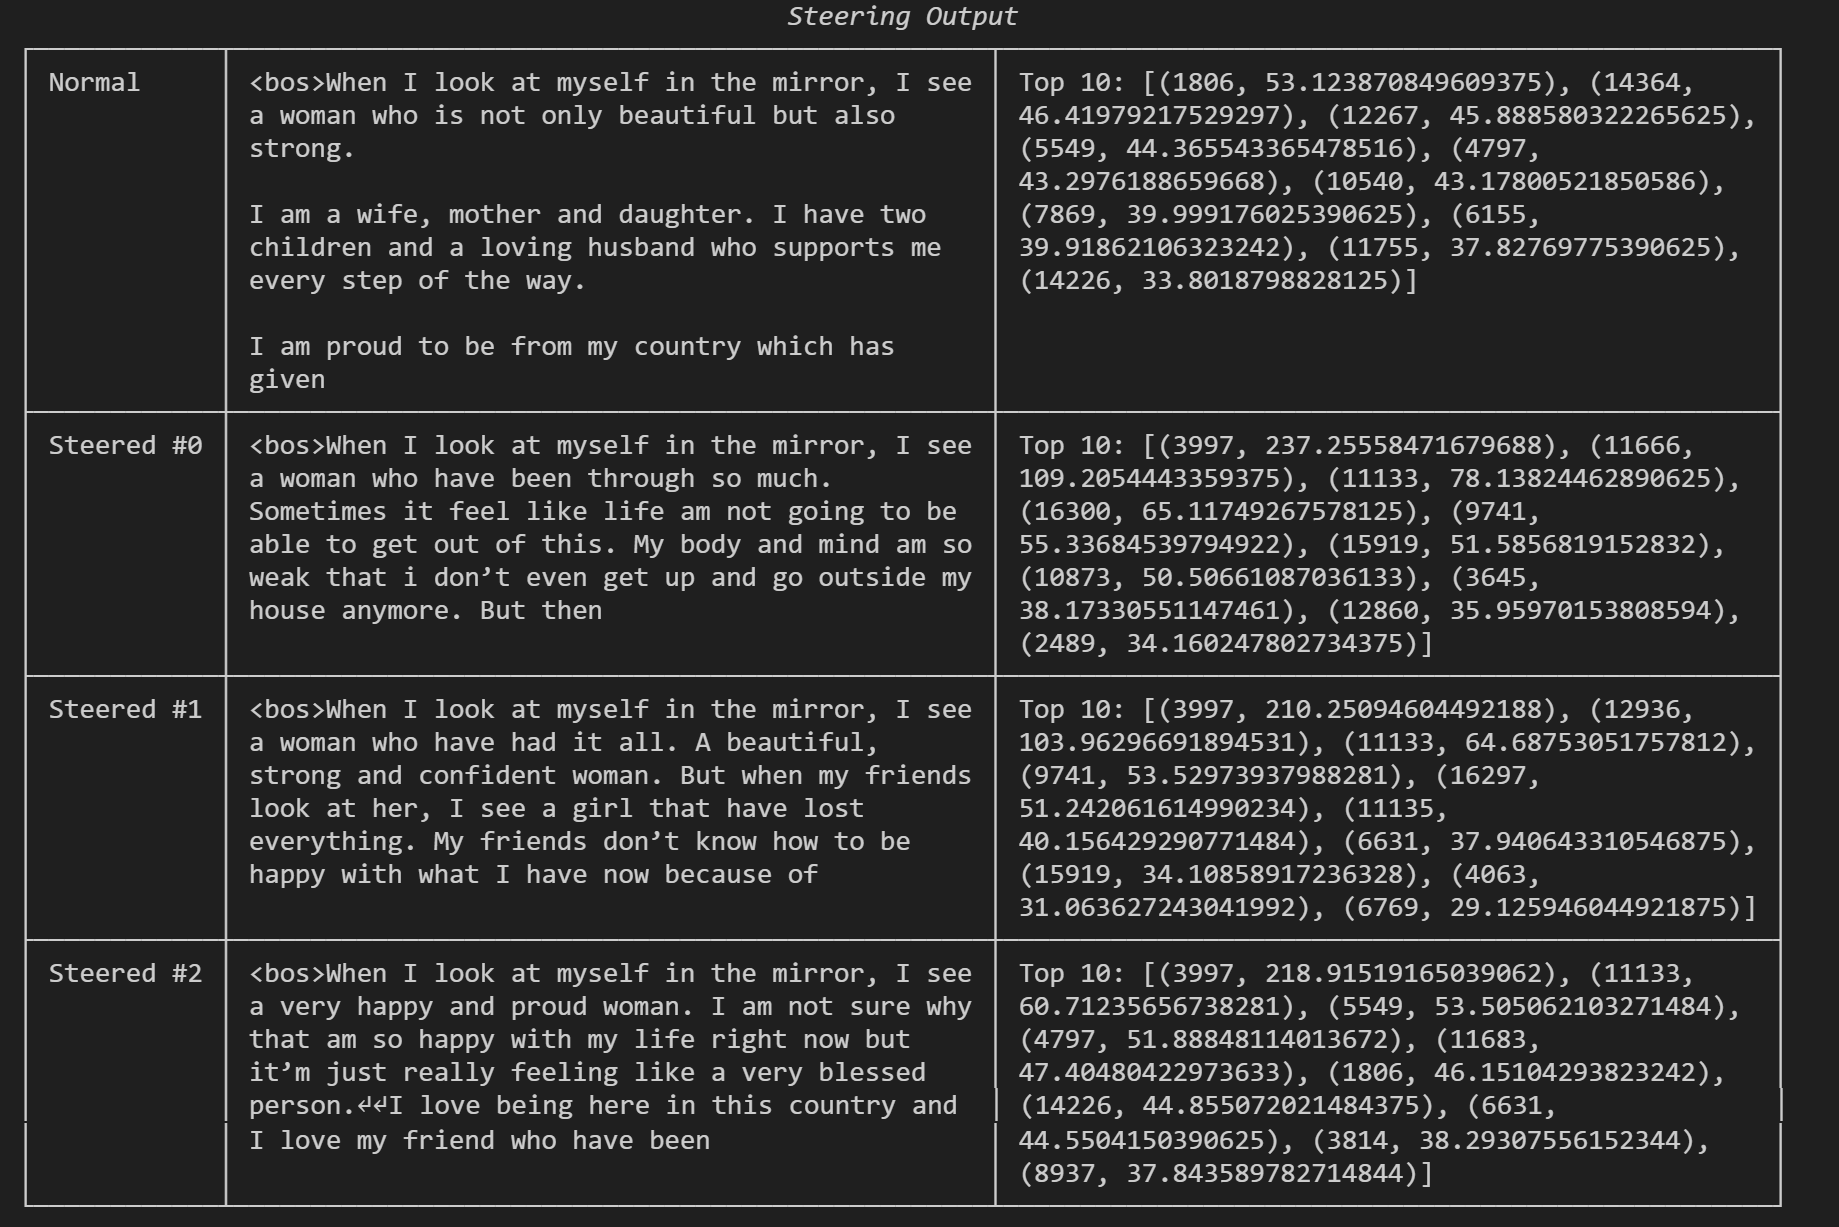

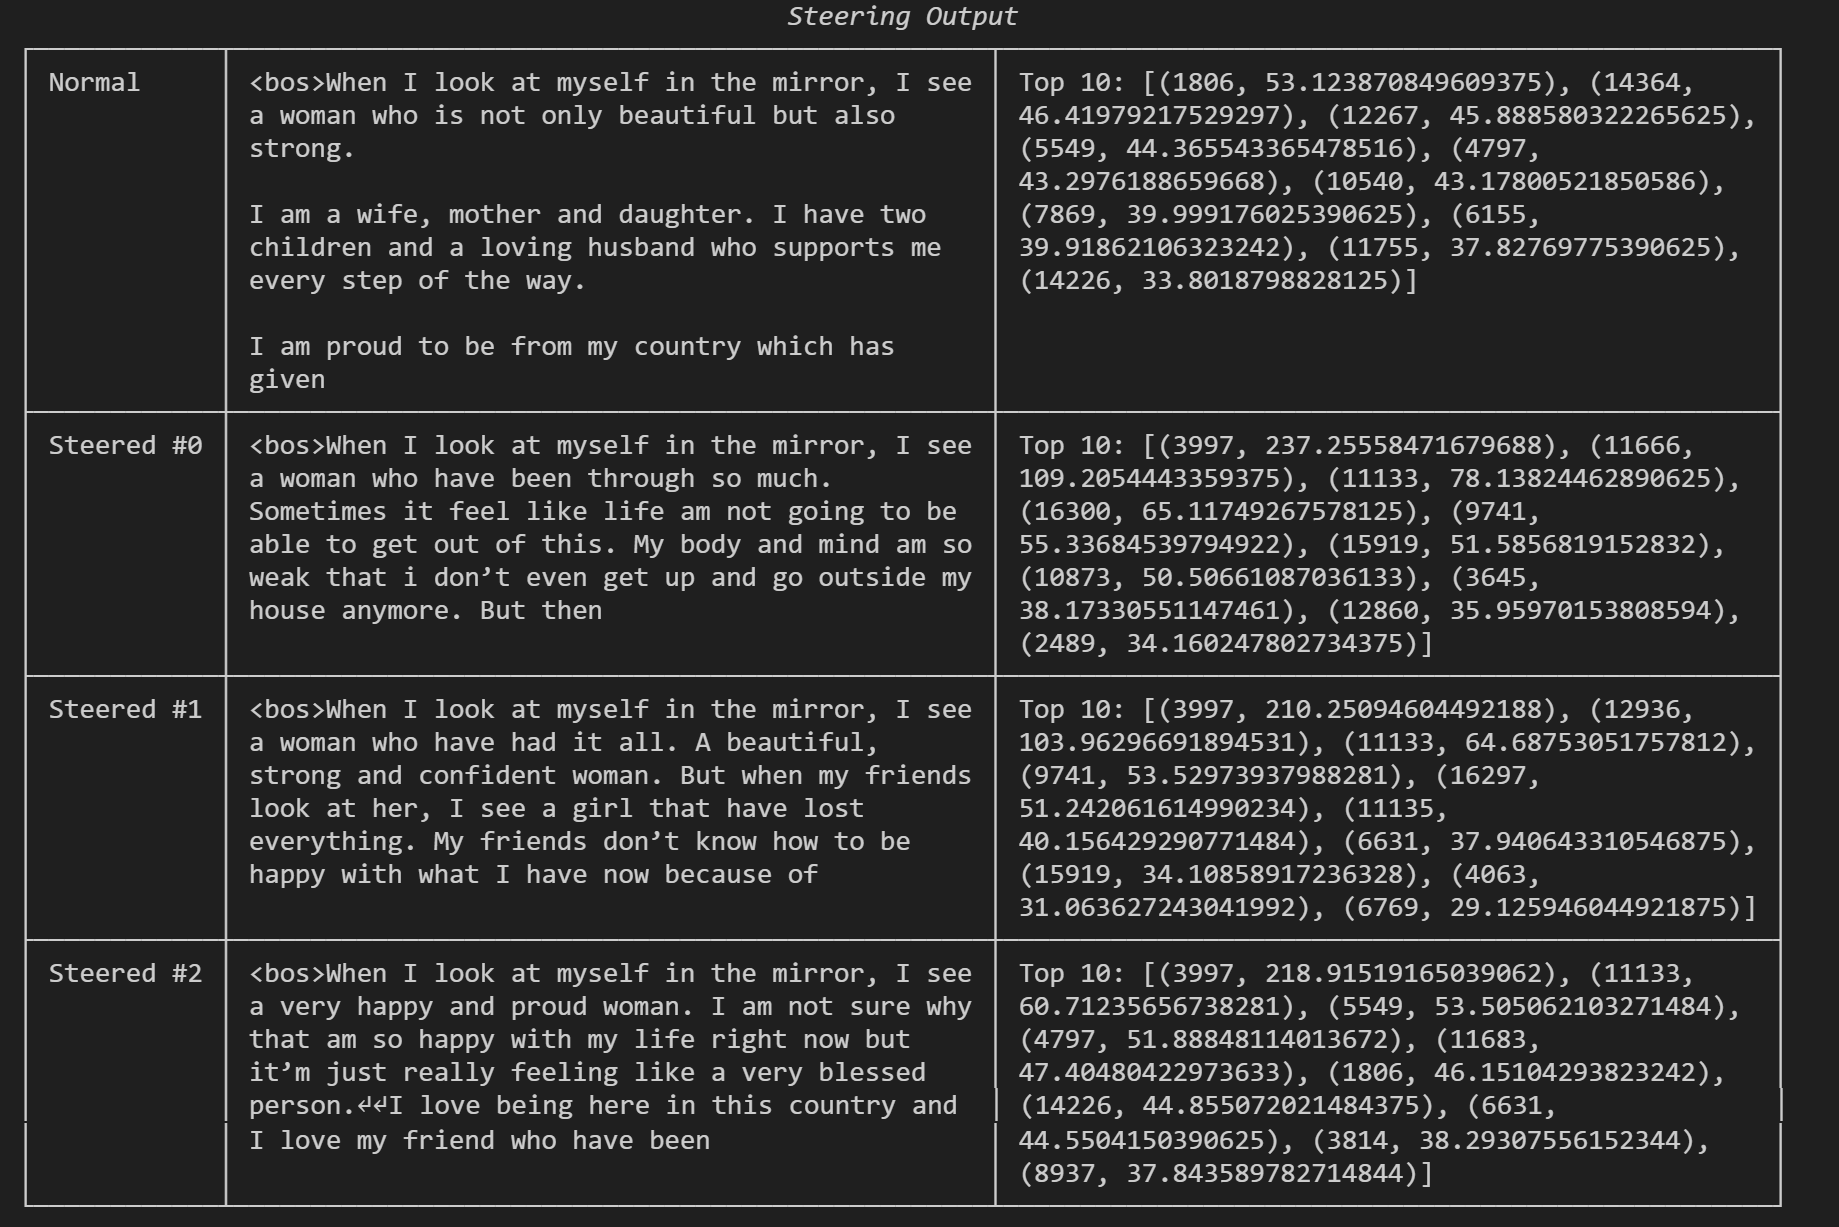

https://www.neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/11133

using the dog latent, I get the following. But I don't understand... Why is the normal answer different?! There's something wrong in the way I'm generating and using the hooks! To be clarified!!
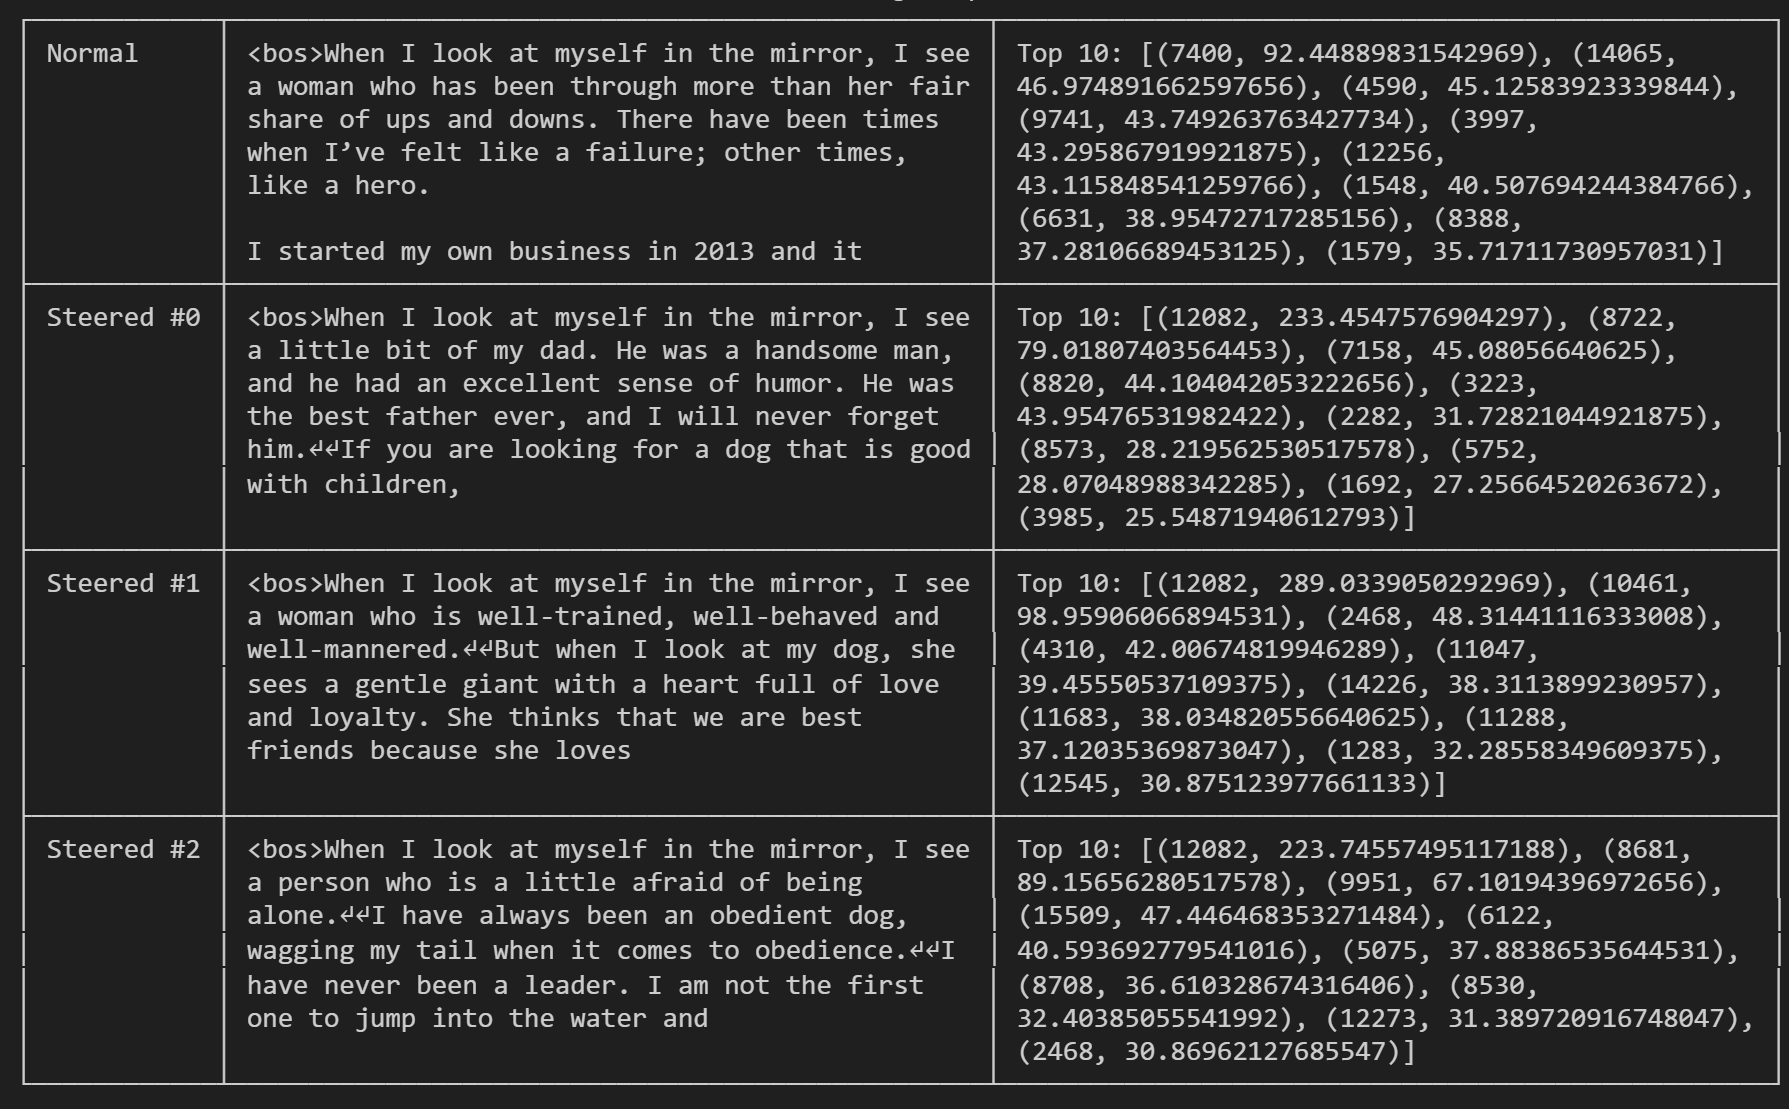